In [56]:
import pandas as pd
import numpy as np

annotations = pd.read_csv('annotations.csv')

In [57]:
# !pip3 install tensorflow

In [58]:
annotations['image_name'] = annotations['image'].apply(lambda x: x.split('/')[-1])

In [59]:
annotations.tail(3)

,image,id,street_width,annotator,annotation_id,pavement_type,pavement_quality,image_name
482,/data/upload/image101angle90.jpg,3,double_car_or_more,1,joana_morgado09@hotmail.com,alcatrao,high,image101angle90.jpg
483,/data/upload/image101angle0.jpg,2,irrelevant_image,1,joana_morgado09@hotmail.com,NaN,NaN,image101angle0.jpg
484,/data/upload/image101_SH65aRx.jpg,1,double_car_or_more,1,joana_morgado09@hotmail.com,paralelo,NaN,image101_SH65aRx.jpg


In [60]:
annotations = pd.concat([annotations, pd.get_dummies(annotations['street_width'])], axis=1)
annotations = annotations.drop(columns=['double_car_or_more'])
# annotations['single_car'] = np.where(annotations['irrelevant_image'] == 1, np.nan, annotations['single_car'])

# remove other predictions in case image is irrelevant
#annotations['pavement_type'] = np.where(annotations['irrelevant_image'] == 1, np.nan, annotations['pavement_type'])
#annotations['pavement_quality'] = np.where(annotations['irrelevant_image'] == 1, np.nan, annotations['pavement_quality'])
#annotations['pavement_quality'] = np.where(annotations['pavement_type'] != 'alcatrao', np.nan, annotations['pavement_quality'])

quality_cols = pd.get_dummies(annotations['pavement_quality'])
quality_cols.columns = [x + '_quality' for x in quality_cols.columns]

annotations = pd.concat([annotations, quality_cols], axis=1)

annotations = pd.concat([annotations, pd.get_dummies(annotations['pavement_type'])], axis=1)

annotations = annotations.drop(columns=['annotation_id', 'pavement_type', 'pavement_quality', 'annotator', 'image'])

Rules for annotation and modeling:

- Whenever image is "irrelevant", dont label anything else
- Whenever type is different from "alcatrão", don't label street quality

In [61]:
annotations.head(3)

,id,street_width,image_name,irrelevant_image,single_car,high_quality,low_quality,mid_quality,alcatrao,paralelo,terra_batida
0,135,irrelevant_image,image26angle180.jpg,1,0,0,0,0,0,0,0
1,66,double_car_or_more,image13angle180.jpg,0,0,0,0,1,1,0,0
2,249,irrelevant_image,image50angle0.jpg,1,0,0,0,0,0,0,0


In [62]:
import re

annotations['image_group'] = annotations.image_name.str.extract(r"(image\d{1,})")

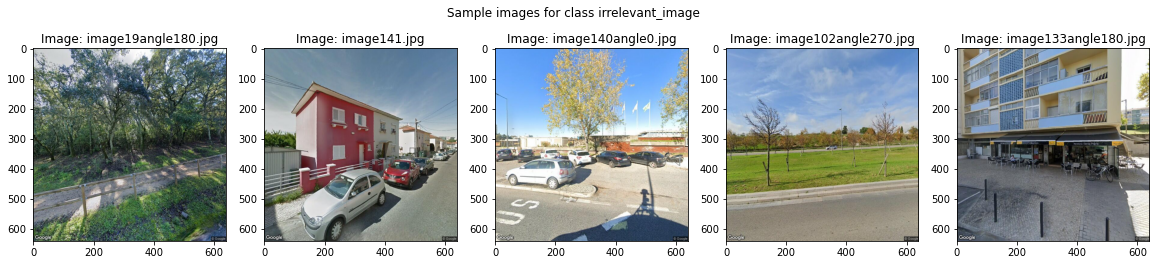

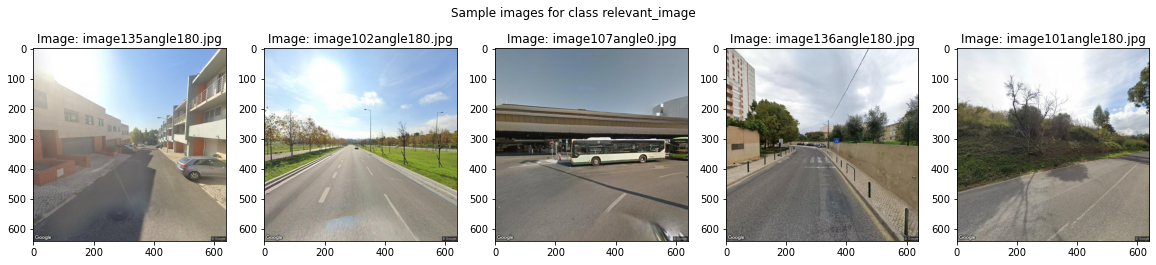

In [68]:
import matplotlib.pyplot as plt
import os

IMAGES_PATH = 'data/images/'
CLASS_NAME = 'irrelevant_image'
#fig1 = plt.imread(IMAGES_PATH + 'image26angle180.jpg')


def make_plot(masked_df, CLASS_NAME):
    images_name = list(masked_df.sample(5, replace=False)['image_name'])
    images = [plt.imread(IMAGES_PATH + x) for x in images_name]
    # Show subplots | shape: (1,3) 
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        plt.imshow(images[i])
        plt.title('Image: {}'.format(images_name[i]))

    plt.suptitle(f'Sample images for class {CLASS_NAME}')
    plt.show()
    
make_plot(annotations[annotations['irrelevant_image'] == 1], 'irrelevant_image')
make_plot(annotations[annotations['irrelevant_image'] == 0], 'relevant_image')

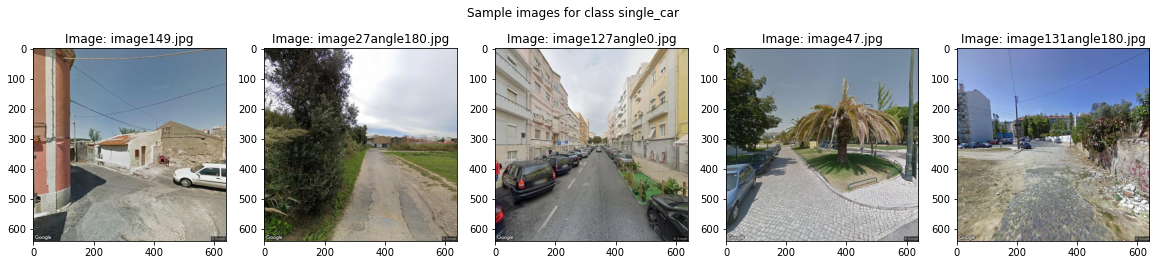

In [69]:
make_plot(annotations[annotations['single_car'] == 1], 'single_car')

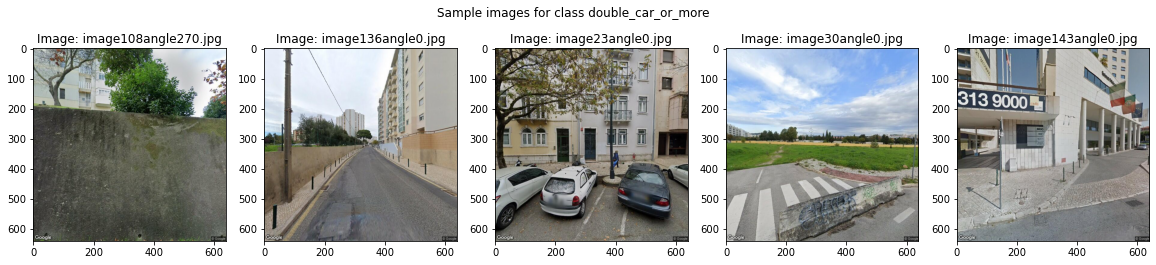

In [70]:
# Fixme: remove irrelevant images for class 0 
make_plot(annotations[annotations['single_car'] == 0], 'double_car_or_more')

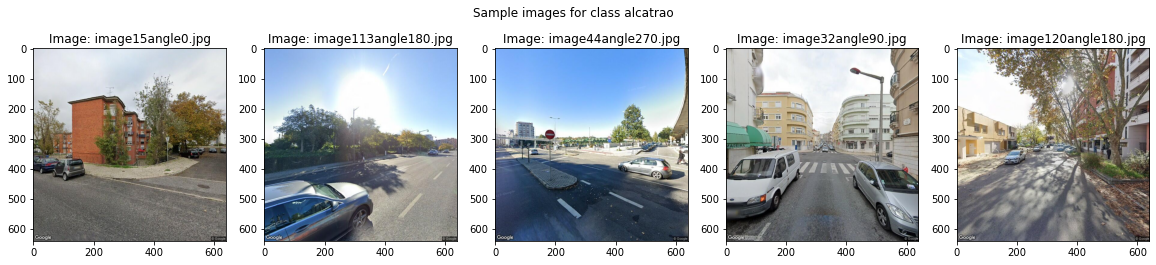

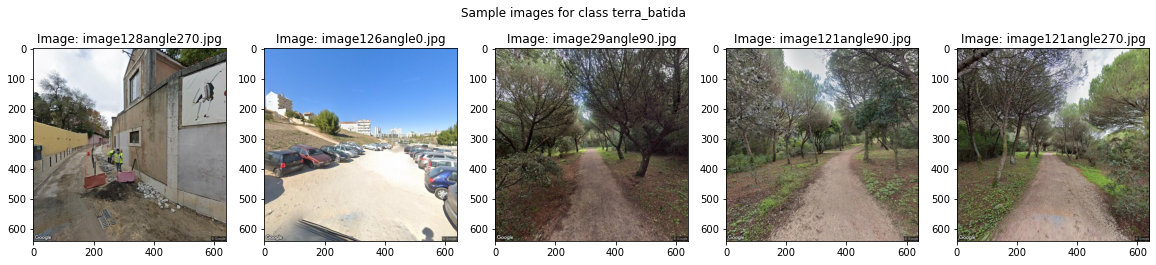

In [72]:
make_plot(annotations[annotations['alcatrao'] == 1], 'alcatrao')
make_plot(annotations[annotations['terra_batida'] == 1], 'terra_batida')

In [79]:
annotations[annotations['paralelo'] == 1].image_name

15              image47.jpg
109       image25angle0.jpg
111     image25angle180.jpg
163             image17.jpg
211       image8angle90.jpg
213      image8angle270.jpg
225       image1angle90.jpg
227      image1angle270.jpg
251      image131angle0.jpg
300     image148angle90.jpg
301      image148angle0.jpg
380    image131angle180.jpg
382    image130angle270.jpg
384     image130angle90.jpg
386            image130.jpg
441    image117angle270.jpg
443     image117angle90.jpg
444      image117angle0.jpg
484    image101_SH65aRx.jpg
Name: image_name, dtype: object

In [75]:
make_plot(annotations[annotations['paralelo'] == 1], 'paralelo')

FileNotFoundError: [Errno 2] No such file or directory: 'data/images/image101_SH65aRx.jpg'

In [ ]:
def model(
    lr=0.0001, input_shape=(224, 224, 3), base_model_trainable=False, model_name = 'irrelevant_vs_relevant'
):

    input_layer = Input(shape=input_shape, name="image")

    base_model = MobileNetV2(
        input_shape=input_shape, weights="imagenet", include_top=False, pooling="max"
    )

    if not base_model_trainable:
        base_model.trainable = False

    x = base_model(input_layer)

    x = Dense(200, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation="relu")(x)
    
    if model_name == 'irrelevant_vs_relevant'
        out = Dense(1, activation="sigmoid", name='irrelevant')(x)
    elif model_name == 'multitask':
        out_width = Dense(1, activation="sigmoid", name='single_car')(x)
        out_pavement = Dense(3, activation="softmax", name='pavement')(x)
    elif model_name == 'quality':
        out = Dense(3, activation='softmax', name='quality')
        
    # TODO: Para o multitask, tens de fazer duas losses
    """
    loss = {
        'single_car': binary_crossentropy,
        'pavement': categorical_crossentropy
    }
    """

    model = Model(input_layer, out)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer, "binary_crossentropy", ["accuracy"])

    return model